**<h1 align="center">Machine Learning Project</h1>**
**<h1 align="center">Predicting Agreement Reached</h1>**

**Group members:**<br> 
Barata Diogo - 20240258 <br>
Deschanel Chloé - 20240693  <br>
Leandro Lara  - 20211632 <br>
Parracho Érica - 20240583 <br>
Walihullah Mohammad - 20230768 <br>

This section is part of the open-ended section of our project. We attempted to predict Agreement Reached because it is identified as important according to the chi-square analysis from feature selection in the main part of the project. The objective of predicting this variable is to see if it could help better predict Claim Injury Type. Indeed, from the EDA, we observed different distributions of this variable among Claim Injury Type, which led us check its predictive capabilities.

# Table of Contents
* [1. Project Setup](#chapter1)
    * [1.1. Imports](#sub-section-1_1)
    * [1.2. Loading Data](#sub-section-1_2)
    * [1.3. Data Type and Duplicates](#sub-section-1_3)
* [2. Data Preparation and Preprocessing](#chapter2)
    * [2.1. Correcting Incoherences](#sub-section-2_1)
    * [2.2. Feature Engineering](#sub-section-2_2)
    * [2.3. Preprocessing](#sub-section-2_3)
* [3. Predicting Agreement Reached](#chapter3)
    * [3.1. Preparing the Data](#sub-section-3_1)
    * [3.2. Feature Selection](#sub-section-3_2)
        * [3.2.1. Chi-Square](#sub-section-3_2_1)
        * [3.2.2. Wrapper Methods - RFE](#sub-section-3_2_2)
        * [3.2.3. Embedded Methods - LASSO](#sub-section-3_2_3)
        * [3.2.4. Final Drops](#sub-section-3_2_4)
    * [3.3. Modeling ](#sub-section-3_3)
        * [3.3.1. KNN ](#sub-section-3_3_1)
        * [3.3.2. Gradient Boosting ](#sub-section-3_3_2)
    * [3.4. Tuning ](#sub-section-3_4)
    * [3.5. Final Model ](#sub-section-3_5)

<a class="anchor" id="chapter1"></a>

# 1. Project Setup

</a>

<a class="anchor" id="sub-section-1_1"></a>

## 1.1. Imports

</a>

In [1]:
import numpy as np
import pandas as pd
import re
from datetime import date

# Created functions in .py file
import functions

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# Data Partition
from sklearn.model_selection import train_test_split

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OrdinalEncoder

# Feature Selection - Filter Methods
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif

# Feature Selection - Wrapper Methods
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Feature Selection - Embedded Methods
from sklearn.linear_model import LassoCV

# Modeling
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier

# Performance Metrics 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.metrics import roc_auc_score

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

<a class="anchor" id="sub-section-1_2"></a>

## 1.2. Loading data

</a>

In [3]:
# Import the train data from the csv file
train_data_original = pd.read_csv("train_data.csv")

# Display all columns
pd.set_option('display.max_columns', None)

# Set Claim Identifier as index
train_data_original.set_index('Claim Identifier', inplace = True)

In [4]:
# Create a copy to work on 
train_data = train_data_original.copy()

<a class="anchor" id="sub-section-1_3"></a>

## 1.3. Data Type and Duplicates

</a>

In [6]:
# Change dates to datetime type
dates = ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date']
train_data[dates] = train_data[dates].apply(pd.to_datetime)

In [7]:
# Drop the duplicated index, as it seems to be an error
train_data = train_data[~train_data.index.duplicated(keep = 'first')]

In [8]:
# Drop duplicated rows
train_data.drop_duplicates(inplace = True) 

<a class="anchor"  id="chapter2"></a>

# 2. Data Preparation and Preprocessing

</a>

<a class="anchor" id="sub-section-2_1"></a>

## 2.1. Correcting Incoherences

</a>

In [11]:
# Missing values in Age at Injury and Birth Year

# Replace values where there is a 0 in Age at Injury and Birth Year with NaN
train_data['Age at Injury'] = train_data['Age at Injury'].replace(0, np.nan)
train_data['Birth Year'] = train_data['Birth Year'].replace(0, np.nan)

# Identify rows where one value is NaN and not the other, and calculate Birth Year
condition = train_data['Birth Year'].isna() & train_data['Age at Injury'].notna()
train_data.loc[condition, 'Birth Year'] = train_data['Accident Date'].dt.year - train_data['Age at Injury']

# Identify rows where one value is NaN and not the other, and calculate Age at Injury
condition = train_data['Age at Injury'].isna() & train_data['Birth Year'].notna()
train_data.loc[condition, 'Age at Injury'] = train_data['Accident Date'].dt.year - train_data['Birth Year']

In [13]:
# Replace with NaN if Age at Injury values are outside of the range 14 and 90 years old
train_data['Age at Injury'] = np.where((train_data['Age at Injury'] > 90) | (train_data['Age at Injury'] < 14), np.nan, train_data['Age at Injury'])

In [14]:
# Replace with NaN if Birth Year is greater than 2008
train_data['Birth Year'] = np.where( train_data['Birth Year']>2008, np.nan, train_data['Birth Year'])

In [15]:
# Clean Carrier Name using clean_carrier_name function
train_data["Carrier Name"] = train_data["Carrier Name"].apply(functions.clean_carrier_name)

In [16]:
# Replace invalid zip codes using replace_invalid_zip_codes function
train_data['Zip Code'] = functions.replace_invalid_zip_codes(train_data['Zip Code'])

In [17]:
# Deal with zip code incoherences
train_data['Zip Code'] = functions.replace_invalid_zip_codes(train_data['Zip Code'])
train_data['Zip Code'].replace("00000", np.nan, inplace=True)
train_data['Zip Code'].replace("99999", np.nan, inplace=True)

In [18]:
# Replace unknown values in County of Injury with NaN
train_data['County of Injury'] = np.where( train_data['County of Injury']=='UNKNOWN', np.nan, train_data['County of Injury'])

In [19]:
# Replace Accident Date with the oldest date provided for that individual
train_data['Accident Date']=np.where(train_data['Assembly Date'] < train_data['Accident Date'],train_data[dates].min(axis=1),
                                     train_data['Accident Date'])

In [20]:
# Replace WCIO Part Of Body Code -9 with code 90
train_data['WCIO Part Of Body Code']=np.where(train_data['WCIO Part Of Body Code'] ==-9,90,train_data['WCIO Part Of Body Code'])

In [21]:
# Replace U values in Alternative Dispute Resolution column with N
train_data['Alternative Dispute Resolution'].replace('U', 'N', inplace=True)

<a class="anchor" id="sub-section-2_2"></a>

## 2.2. Feature Engineering

</a>

In [23]:
# Calculate the current Age based on Birth Year and current date 
train_data["Age"]= date.today().year - train_data["Birth Year"]

In [24]:
# Create a binary variable with 1 if the C3 date is no an empty value and 0 otherwise
train_data["C3_Received"] = train_data["C-3 Date"].notna().astype(int)

In [25]:
# Create a binary variable with 1 if the C2 date is no an empty value and 0 otherwise
train_data["C2_Received"] = train_data["C-2 Date"].notna().astype(int)

In [26]:
# Create a binary variable with 1 if the First Hearing is no an empty value and 0 otherwise
train_data["First_Hearing"] = train_data["First Hearing Date"].notna().astype(int)

In [27]:
# Create a variable with the number of days between the current date and the Assembly Date
train_data['Days_from_Assembly Date'] = (pd.Timestamp.today() - train_data['Assembly Date']).dt.days

In [28]:
# Create a variable and extract the accident year from the Accident Date to facilitate understanding 
train_data["Accident Year"] = train_data["Accident Date"].dt.year

In [29]:
# Create a binary variable with 1 if the individual has a dependent and O if not
train_data['Has_Dependents'] = train_data['Number of Dependents'].apply(lambda x: 1 if x > 0 else 0)

In [30]:
# Do the log transformation of Wage to help reduce skewness in the data (+1 ensures all values have a log)
train_data['Average Weekly Wage'] = train_data['Average Weekly Wage'].apply(lambda x: np.log(x + 1))

In [31]:
# Do the log transformation of IME-4 Count to help reduce skewness in the data (+1 ensures all values have a log)
train_data['IME-4 Count'] = train_data['IME-4 Count'].apply(lambda x: np.log(x + 1))

In [32]:
# Drop unused variables
train_data.drop('Birth Year', axis = 1, inplace = True)
train_data.drop('C-3 Date', axis = 1, inplace = True) 
train_data.drop("First Hearing Date", axis = 1, inplace = True)
train_data.drop("Accident Date", axis = 1, inplace = True)
train_data.drop("Assembly Date", axis = 1, inplace = True)
train_data.drop("C-2 Date", axis = 1, inplace = True)

In [33]:
# Drop code descriptions
train_data.drop('Industry Code Description', axis = 1, inplace = True)
train_data.drop('WCIO Cause of Injury Description', axis = 1, inplace = True)
train_data.drop('WCIO Nature of Injury Description', axis = 1, inplace = True)
train_data.drop('WCIO Part Of Body Description', axis = 1, inplace = True)

<a class="anchor" id="sub-section-2_3"></a>

## 2.3. Preprocessing

</a>


For the preprocessing, we decided to use the same preprocessing steps as the ones for our main target. For more simplicity, we will use a function of a majority of the process.

In [44]:
train_data.dropna(subset=["Claim Injury Type"], inplace=True)

In [45]:
# Split the data set into features and target 
data = train_data.drop(columns=["Claim Injury Type"])
target = train_data["Claim Injury Type"]

In [46]:
# Split into the train and valiations sets
X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.2, random_state=5, stratify=target)

In [47]:
# Use the preprocessing function that applies all the same steps as the ones in the main notebook
X_train_scaled, X_val_scaled=functions.preprocess_X(X_train, X_val)

In [48]:
# Encode the target on train and val
enc2 = LabelEncoder()  

y_train_enc=enc2.fit_transform(y_train)
y_val_enc=enc2.transform(y_val)
y_train = pd.Series(y_train_enc, index=y_train.index)
y_val= pd.Series(y_val_enc, index=y_val.index)

<a class="anchor"  id="chapter3"></a>

# 3. Predicting Agreement Reached

</a>

<a class="anchor" id="sub-section-3_1"></a>

## 3.1. Preparing the Data

</a>

In [51]:
X_train_agr = X_train_scaled.copy()
X_val_agr = X_val_scaled.copy()

In [52]:
# Check distribution of the variable in train set
X_train_agr["Agreement Reached"].value_counts(normalize=True)

Agreement Reached
0.0    0.95331
1.0    0.04669
Name: proportion, dtype: float64

In [53]:
# Check distribution of the variable in the validation set 
X_val_agr["Agreement Reached"].value_counts(normalize=True)

Agreement Reached
0.0    0.953434
1.0    0.046566
Name: proportion, dtype: float64

The distributions in the training and validation set are similar, and so, there is no need to split the data again.

In [59]:
# Adjust the target and feature variables for the new model
y_train_agr = X_train_agr["Agreement Reached"]
X_train_agr = X_train_agr.drop(columns=["Agreement Reached"])
y_val_agr = X_val_agr["Agreement Reached"]
X_val_agr = X_val_agr.drop(columns=["Agreement Reached"])

<a class="anchor" id="sub-section-3_2"></a>

## 3.2. Feature Selection

</a>

For feature selection techniques that are not dependent on the target variable, we already know that we need to drop some features:
- Univariate: WCB Decision 
- Correlated features: Age or Age at Injury,  Accident Year or Days_from_Assembly Date
    - These will be included in the test to see which one should be kept, and one of each pair will be dropped in 3.2.4 Final Drops.

In [73]:
X_train_agr.drop('WCB Decision', axis=1, inplace=True)
X_val_agr.drop('WCB Decision', axis=1, inplace=True)

For feature selection techniques that are dependent on the target variable, we are going to reproduce the feature selection techniques used in Claim Injury Type feature selection, as well as the same decision thresholds. But, this time we will consider the new target.

In [76]:
numerical_columns = ['Age at Injury', 'Average Weekly Wage', 'Number of Dependents', 'Age', 'IME-4 Count', 
                     'Accident Year', 'Days_from_Assembly Date', 'Alternative Dispute Resolution',
                     'Attorney/Representative', 'COVID-19 Indicator', 'C3_Received','C2_Received', 
                     'First_Hearing', 'Has_Dependents']

categorical_columns = ['Alternative Dispute Resolution', 'Attorney/Representative', 'Carrier Name', 
                       'Carrier Type', 'County of Injury', 'COVID-19 Indicator', 'District Name', 
                       'Gender', 'Industry Code', 'Medical Fee Region', 'WCIO Cause of Injury Code', 
                       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code', 'C3_Received', 
                       'C2_Received', 'First_Hearing', 'Has_Dependents']

<a class="anchor" id="sub-section-3_2_1"> </a>

###  3.2.1. Chi-Square

</a>

The Chi-square test can help determine if there is a significant association between each categorical feature and the target.

In [83]:
# Test each variables against the target
for var in X_train[categorical_columns]:
    functions.TestIndependence(X_train_agr[categorical_columns][var],y_train_agr, var)

Alternative Dispute Resolution is IMPORTANT for Prediction
Attorney/Representative is IMPORTANT for Prediction
Carrier Name is IMPORTANT for Prediction
Carrier Type is IMPORTANT for Prediction
County of Injury is IMPORTANT for Prediction
COVID-19 Indicator is IMPORTANT for Prediction
District Name is IMPORTANT for Prediction
Gender is IMPORTANT for Prediction
Industry Code is IMPORTANT for Prediction
Medical Fee Region is IMPORTANT for Prediction
WCIO Cause of Injury Code is IMPORTANT for Prediction
WCIO Nature of Injury Code is IMPORTANT for Prediction
WCIO Part Of Body Code is IMPORTANT for Prediction
Zip Code is IMPORTANT for Prediction
C3_Received is IMPORTANT for Prediction
C2_Received is IMPORTANT for Prediction
First_Hearing is IMPORTANT for Prediction
Has_Dependents is NOT an important predictor. (Discard Has_Dependents from model)


<a class="anchor" id="sub-section-3_2_2"> </a>

###  3.2.2 Wrapper Methods - RFE

</a>

The Recursive Feature Elimination allows is to select the most important features to keep by running a predictive model, in this case Logistic Regression, multiple times and removing the "least important" at each iteration.

In [94]:
# Define the number of features to evaluate (from 1 to 14 features)
nof_list = np.arange(1, 15)

# Variables/lists to store the best score and number of features
high_score = 0
nof = 0           
train_score_list = []
val_score_list = []

# Iterate over each possible number of features (from 1 to 15)
for n in range(len(nof_list)):
    
    # Initialize a logistic regression model
    model = LogisticRegression()
    
    # Perform RFE to select 'n' features
    rfe = RFE(estimator=model, n_features_to_select=nof_list[n])
    
    # Apply RFE to the training & validation data, selecting the top 'n' features
    X_train_rfe = rfe.fit_transform(X_train_agr[numerical_columns], y_train)
    X_val_rfe = rfe.transform(X_val_agr[numerical_columns])
    
    # Fit the logistic regression model on the selected features from the training data
    model.fit(X_train_rfe, y_train_agr)
    
    # Predict probabilities for the training and validation datasets
    y_train_pred = model.predict_proba(X_train_rfe)[:, 1]  # Taking the probability for the positive class
    y_val_pred = model.predict_proba(X_val_rfe)[:, 1]    # Same for validation set
    
    # Calculate the ROC AUC score on the training and validation data
    train_score = roc_auc_score(y_train_agr, y_train_pred)
    val_score = roc_auc_score(y_val_agr, y_val_pred)
    
    train_score_list.append(train_score)
    val_score_list.append(val_score)
    
    # Check if the current validation score is higher than the best score so far
    if val_score >= high_score:
        high_score = val_score
        nof = nof_list[n]

print("Optimum number of features: %d" % nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 13
Score with 13 features: 0.890629


In [95]:
# Initialize the RFE model with a Logistic Regression estimator & set number of features to 13
rfe = RFE(estimator = model, n_features_to_select = 13)

# Apply RFE to the scaled training data with the specified numerical columns
X_rfe = rfe.fit_transform(X = X_train_agr[numerical_columns], y = y_train_agr)

In [96]:
# Create a pandas Series to see if a feature is selected or not
selected_features = pd.Series(rfe.support_, index = X_train_agr[numerical_columns].columns)
selected_features

Age at Injury                      True
Average Weekly Wage                True
Number of Dependents              False
Age                                True
IME-4 Count                        True
Accident Year                      True
Days_from_Assembly Date            True
Alternative Dispute Resolution     True
Attorney/Representative            True
COVID-19 Indicator                 True
C3_Received                        True
C2_Received                        True
First_Hearing                      True
Has_Dependents                     True
dtype: bool

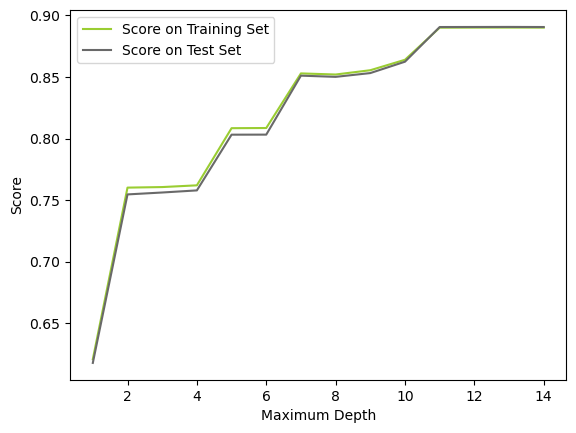

In [97]:
# Plot how training accuracy and validation accuracy vary with the number of features
plt.plot(list(range(1,15)), train_score_list, label="Score on Training Set", color='yellowgreen')
plt.plot(list(range(1,15)), val_score_list, label="Score on Test Set", color='dimgray')
plt.xlabel("Maximum Depth")
plt.ylabel("Score")
plt.legend()
plt.show()

<a class="anchor" id="sub-section-3_2_3"> </a>

### 3.2.3 Embedded Methods - Lasso

</a>

Lasso allows us to determine which variable is insignicant (i.e. coefficient == 0).

In [100]:
# Initialize a Lasso Regression
Lreg = LassoCV()

In [101]:
# Fit the data to the regression 
Lreg.fit(X_train_agr[numerical_columns], y_train_agr)

LassoCV()

In [102]:
coef = pd.Series(Lreg.coef_, index = X_train_agr[numerical_columns].columns)
coef

Age at Injury                    -1.126959
Average Weekly Wage              -0.073834
Number of Dependents             -0.000000
Age                               1.088765
IME-4 Count                       0.143161
Accident Year                    -0.099958
Days_from_Assembly Date          -0.049425
Alternative Dispute Resolution    0.017392
Attorney/Representative           0.091829
COVID-19 Indicator               -0.015243
C3_Received                      -0.013292
C2_Received                       0.053099
First_Hearing                     0.040569
Has_Dependents                    0.000525
dtype: float64

<a class="anchor" id="sub-section-3_2_4"> </a>

### 3.2.4. Final Drops

</a>

According to the feature selection tests, the following variables should be dropped:
- Correlated features: Age or Age at Injury, Days_from_Assembly Date or Accident Year
- Chi-square: Has_Dependents
- RFE: Number of Dependents 
- Lasso: Number of Dependents

Final considerations:
- Only Age, Days_from_Assembly Date, and Number of Dependents will be dropped.
    - Age has a lower score than Age at Injury according to Lasso.
    - Days_from_Assembly Date has a lower score than Accident Year according to Lasso.
    - Number of Dependents failed in RFE and Lasso.
- Has_dependents was only flagged once, and following our decision criteria, this categorical variable should remain in the model.

In [112]:
X_train_agr.drop('Age', axis=1, inplace=True)
X_val_agr.drop('Age', axis=1, inplace=True)

In [114]:
X_train_agr.drop('Days_from_Assembly Date', axis=1, inplace=True)
X_val_agr.drop('Days_from_Assembly Date', axis=1, inplace=True)

In [116]:
X_train_agr.drop('Number of Dependents', axis=1, inplace=True)
X_val_agr.drop('Number of Dependents', axis=1, inplace=True)

In [118]:
# Check the remaining features
X_train_agr.columns

Index(['Age at Injury', 'Alternative Dispute Resolution',
       'Attorney/Representative', 'Average Weekly Wage', 'Carrier Name',
       'Carrier Type', 'County of Injury', 'COVID-19 Indicator',
       'District Name', 'Gender', 'IME-4 Count', 'Industry Code',
       'Medical Fee Region', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code',
       'C3_Received', 'C2_Received', 'First_Hearing', 'Accident Year',
       'Has_Dependents'],
      dtype='object')

<a class="anchor" id="sub-section-3_3"></a>

## 3.3. Modeling

</a>

In this section, we will try three models to predict Agreement Reached:
- KNN
- Gradient Boosting
- Random Forest

<a class="anchor" id="sub-section-3_3_1"></a>

### 3.3.1. KNN

</a>

In [123]:
# Set range of k values that will be tested
k_values = range(1, 12) 

# Initialize variables 
best_f1_score = 0
best_k = 0
f1_scores = []

# Run knn between k=1 and k=9 to get the best result
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance') 
    knn.fit(X_train_agr, y_train_agr)
    y_pred = knn.predict(X_val_agr)
    
    f1 = f1_score(y_val_agr, y_pred, average='macro')
    
    # Get the best k value based on f1 score (macro)
    if f1 > best_f1_score:
        best_f1_score = f1
        best_k = k

    f1_scores.append(f1)

print("F1_Scores for each k value:")
for k, f1 in zip(k_values, f1_scores):
    print(f"k = {k} -> F1 Score: {f1:.4f}")

F1_Scores for each k value:
k = 1 -> F1 Score: 0.6232
k = 2 -> F1 Score: 0.6232
k = 3 -> F1 Score: 0.6210
k = 4 -> F1 Score: 0.6201
k = 5 -> F1 Score: 0.6093
k = 6 -> F1 Score: 0.6104
k = 7 -> F1 Score: 0.5999
k = 8 -> F1 Score: 0.5998
k = 9 -> F1 Score: 0.5923
k = 10 -> F1 Score: 0.5917
k = 11 -> F1 Score: 0.5864


In [124]:
knn = KNeighborsClassifier(n_neighbors=1)  

In [125]:
knn.fit(X_train_agr, y_train_agr)
y_pred_val_knn_agr = knn.predict(X_val_agr)

In [126]:
class_report = classification_report(y_val_agr, y_pred_val_knn_agr, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()
print("Classification Report for Validation:")
class_report_df

Classification Report for Validation:


,precision,recall,f1-score,support
0.0,0.964740,0.966097,0.965418,109459.00000
1.0,0.285247,0.277030,0.281078,5346.00000
accuracy,0.934010,0.934010,0.934010,0.93401
macro avg,0.624993,0.621563,0.623248,114805.00000
weighted avg,0.933098,0.934010,0.933551,114805.00000


In [127]:
conf_matrix = confusion_matrix(y_val_agr, y_pred_val_knn_agr)
conf_matrix = pd.DataFrame(conf_matrix)
print('Confusion Matrix for Validation:')
conf_matrix

Confusion Matrix for Validation:


,0,1
0,105748,3711
1,3865,1481


<a class="anchor" id="sub-section-3_3_2"></a>

### 3.3.2. Gradient Boosting

</a>

In [136]:
GB = xgb.XGBClassifier(random_state=42, verbosity=1)

In [138]:
GB.fit(X_train_agr, y_train_agr)
y_pred_val_GB_agr = GB.predict(X_val_agr)
y_pred_train_GB_agr = GB.predict(X_train_agr)

In [139]:
class_report = classification_report(y_train_agr, y_pred_train_GB_agr, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()
print("Classification Report for Training:")
class_report_df

Classification Report for Training:


,precision,recall,f1-score,support
0.0,0.963366,0.997140,0.979962,437779.000000
1.0,0.794518,0.225782,0.351638,21441.000000
accuracy,0.961125,0.961125,0.961125,0.961125
macro avg,0.878942,0.611461,0.665800,459220.000000
weighted avg,0.955482,0.961125,0.950625,459220.000000


In [140]:
class_report = classification_report(y_val_agr, y_pred_val_GB_agr, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()
print("Classification Report for Validation:")
class_report_df

Classification Report for Validation:


,precision,recall,f1-score,support
0.0,0.961044,0.995286,0.977865,109459.00000
1.0,0.643154,0.173962,0.273852,5346.00000
accuracy,0.957040,0.957040,0.957040,0.95704
macro avg,0.802099,0.584624,0.625858,114805.00000
weighted avg,0.946241,0.957040,0.945082,114805.00000


In [141]:
conf_matrix = confusion_matrix(y_val_agr, y_pred_val_GB_agr)
conf_matrix = pd.DataFrame(conf_matrix)
print('Confusion Matrix for Validation:')
conf_matrix

Confusion Matrix for Validation:


,0,1
0,108943,516
1,4416,930


<a class="anchor" id="sub-section-3_3_3"></a>

### 3.3.3. Random Forest

</a>

In [147]:
rf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=None, class_weight='balanced')

In [149]:
rf.fit(X_train_agr, y_train_agr)
y_pred_val_rf_agr = rf.predict(X_val_agr)

In [150]:
class_report_rf = classification_report(y_val_agr, y_pred_val_rf_agr, output_dict=True)
class_report_rf_df = pd.DataFrame(class_report_rf).transpose()
print("Classification Report for Validation:")
class_report_rf_df

Classification Report for Validation:


,precision,recall,f1-score,support
0.0,0.958207,0.998081,0.977738,109459.000000
1.0,0.734513,0.108679,0.189343,5346.000000
accuracy,0.956666,0.956666,0.956666,0.956666
macro avg,0.846360,0.553380,0.583541,114805.000000
weighted avg,0.947790,0.956666,0.941025,114805.000000


In [151]:
conf_matrix_rf = confusion_matrix(y_val_agr, y_pred_val_rf_agr)
conf_matrix_rf_df = pd.DataFrame(conf_matrix_rf)
print("Confusion Matrix for Validation:")
conf_matrix_rf_df

Confusion Matrix for Validation:


,0,1
0,109249,210
1,4765,581


From the three models, it seems that Gradient Boosting is a good model. It has a higher macro F1-score (0.625858) than Random Forest (0.583541), meaning there is a good balance between Precision and Recall. Indeed, even though RF has a higher Precision (0.734513) for the minority (1.0), it has a very poor Recall score for this class (0.108679). Now, comparing GB and KNN, GB has a much higher Precision for the minority class (0.643154), than KNN (0.285247). This makes GB more reliable to correctly identify positive cases and minimising false positives. 

<a class="anchor" id="sub-section-3_4"></a>

## 3.4. Tuning

</a>

From the results of the three models, we can see that Gradient Boosting provides the best results, and so, we will tune the model using GridSearchCV() to find the best parameters.

In [86]:
#parameter_space = {
#    'n_estimators': [100, 300, 500], 
#    'max_depth': [3, 7, 10], 
#    'learning_rate': [0.01, 0.1, 0.2], 
#    'subsample': [0.7, 1.0], 
#    'colsample_bytree': [0.7, 1.0], 
#    'min_child_weight': [1, 5, 10], 
#    'max_delta_step': [0, 3],
#    'gamma': [0, 0.4],  # 3 options
#    'objective': ['binary:logistic'],  
#    'scale_pos_weight': [5, 7],  
#    'reg_alpha': [0, 0.5],  
#    'reg_lambda': [1, 2]}

#gb = xgb.XGBClassifier(random_state=42, verbosity=1)

#X_combined = np.concatenate([X_train_agr, X_val_agr])
#y_combined = np.concatenate([y_train_agr, y_val_agr])
#test_fold = [-1] * len(X_train_agr) + [0] * len(X_val_agr)
#ps = PredefinedSplit(test_fold=test_fold)

#clf_gb = GridSearchCV(
#    estimator=gb,
#    param_grid=param_grid,
#    scoring='f1_macro',  
#    cv=ps,                
#    verbose=5,           
#    n_jobs=-2)
 

#clf_gb.fit(X_combined, y_combined)

#print("Best Hyperparameters:", clf_gb.best_params_)
#print("Best Score:", clf_gb.best_score_)

Fitting 1 folds for each of 100 candidates, totalling 100 fits
Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0.6, 'learning_rate': 0.1, 'max_delta_step': 3, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 300, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 2, 'scale_pos_weight': 5, 'subsample': 1.0}
Best Score: 0.7131992272994387


<a class="anchor" id="sub-section-3_5"></a>

## 3.5. Final Model

</a>

In [156]:
tuned_model = xgb.XGBClassifier(colsample_bytree=1.0,gamma=0.4,learning_rate=0.1,max_delta_step=3,max_depth=10,
    min_child_weight=5,n_estimators=300,reg_alpha=0,reg_lambda=2,scale_pos_weight=5,subsample=1.0,random_state=42)


tuned_model.fit(X_train_agr, y_train_agr)
y_pred_val_tuned = tuned_model.predict(X_val_agr)
y_pred_train_tuned = tuned_model.predict(X_train_agr)

# Metrics for assessment
f1_val_tuned=f1_score(y_val_agr, y_pred_val_tuned, average='macro')

print('Accuracy on Train Set:', accuracy_score(y_train_agr, y_pred_train_tuned))
print('Training F1 Macro:', f1_score(y_train_agr, y_pred_train_tuned, average='macro'))
print('Accuracy on Validation Set:', accuracy_score(y_val_agr, y_pred_val_tuned))
print('Validation F1 Macro:',f1_val_tuned)


class_report = classification_report(y_val_agr, y_pred_val_tuned, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()
class_report_df

Accuracy on Train Set: 0.968041461608815
Training F1 Macro: 0.8573886673414572
Accuracy on Validation Set: 0.9368407299333653
Validation F1 Macro: 0.7111955202805519


,precision,recall,f1-score,support
0.0,0.978394,0.954842,0.966474,109459.000000
1.0,0.380654,0.568275,0.455917,5346.000000
accuracy,0.936841,0.936841,0.936841,0.936841
macro avg,0.679524,0.761558,0.711196,114805.000000
weighted avg,0.950560,0.936841,0.942700,114805.000000


After tuning, we can see that the macore F1-score improved from 0.625858 to 0.711196. It also improved Class 1's macro F1-score from 0.273852 to 0.455917, which shows a better balance between Precision and Recall for the minority class. We can also observe that there is a slight decrease in precision and overall accuracy, but the tuned model does a better job at predicting the minority class, which is important as there is an imbalance.  